# 2. Feature Engineering

In [1]:
import pandas as pd

from paths import DATA_DIR, PROCESSED_CSV_FILE, FEATURE_ENG_DIR, ENGINEERED_CSVS_DIR, LOGS_DIR
from helpers.constants import TARGETS
from ml_tools.logger import custom_logger
from ml_tools.utilities import load_dataframe, save_dataframe, merge_dataframes, serialize_object
from ml_tools.data_exploration import info
info()

Available functions and objects:
1 - summarize_dataframe
2 - drop_rows_with_missing_data
3 - split_features_targets
4 - show_null_columns
5 - drop_columns_with_missing_data
6 - split_continuous_binary
7 - plot_correlation_heatmap
8 - check_value_distributions
9 - plot_value_distributions
10 - clip_outliers_single
11 - clip_outliers_multi


In [ ]:
from ml_tools.data_exploration import summarize_dataframe, drop_rows_with_missing_data, split_features_targets, show_null_columns, drop_columns_with_missing_data, split_continuous_binary, plot_correlation_heatmap, plot_value_distributions, clip_outliers_multi, match_and_filter_columns_by_regex

## 1. Load dataset

In [5]:
df_raw, _ = load_dataframe(df_path=PROCESSED_CSV_FILE)


💿 Loaded dataset: 'preprocessed_data' with shape: (1220, 123)


In [6]:
summarize_dataframe(df_raw)

Shape: (1220, 123)


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
coating_material,float64,640,2,47.54,0.71,0.45,0.0,0.0,1.0,1.0,1.00
dopant_Li,int64,1220,2,0.00,0.00,0.06,0.0,0.0,0.0,0.0,1.00
dopant_B,int64,1220,2,0.00,0.02,0.14,0.0,0.0,0.0,0.0,1.00
dopant_C,int64,1220,2,0.00,0.00,0.03,0.0,0.0,0.0,0.0,1.00
dopant_N,int64,1220,2,0.00,0.03,0.17,0.0,0.0,0.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
molar_ratio_C,float64,1220,6,0.00,0.00,0.01,0.0,0.0,0.0,0.0,0.20
molar_ratio_Se,float64,1220,2,0.00,0.00,0.02,0.0,0.0,0.0,0.0,0.50
molar_ratio_La,float64,1220,11,0.00,0.01,0.07,0.0,0.0,0.0,0.0,1.00
molar_ratio_Gd,float64,1220,4,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.01


In [7]:
df_full = drop_rows_with_missing_data(df=df_raw, threshold=0.3)

No rows have more than 30% missing data.


In [8]:
summarize_dataframe(df_full)

Shape: (1220, 123)


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
coating_material,float64,640,2,47.54,0.71,0.45,0.0,0.0,1.0,1.0,1.00
dopant_Li,int64,1220,2,0.00,0.00,0.06,0.0,0.0,0.0,0.0,1.00
dopant_B,int64,1220,2,0.00,0.02,0.14,0.0,0.0,0.0,0.0,1.00
dopant_C,int64,1220,2,0.00,0.00,0.03,0.0,0.0,0.0,0.0,1.00
dopant_N,int64,1220,2,0.00,0.03,0.17,0.0,0.0,0.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
molar_ratio_C,float64,1220,6,0.00,0.00,0.01,0.0,0.0,0.0,0.0,0.20
molar_ratio_Se,float64,1220,2,0.00,0.00,0.02,0.0,0.0,0.0,0.0,0.50
molar_ratio_La,float64,1220,11,0.00,0.01,0.07,0.0,0.0,0.0,0.0,1.00
molar_ratio_Gd,float64,1220,4,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.01


## 2. Get splits (Features, Target)

In [9]:
df_features, df_targets = split_features_targets(df=df_full, targets=TARGETS)

Original shape: (1220, 123)
Features shape: (1220, 120)
Targets shape: (1220, 3)


## 3. Null values

In [10]:
null_cols_features = show_null_columns(df_features)
null_cols_features

,Missing Count,Missing %
annealing_time_3(hour),1142,93.61
annealing_temperature_3(K),1141,93.52
precursor_temperature,1051,86.15
precursor_pH,1045,85.66
particle_size_secondary(um),818,67.05
annealing_time_2(hour),708,58.03
annealing_temperature_2(K),688,56.39
particle_size_primary(um),676,55.41
coating_material,580,47.54
electrolyte_molarity,517,42.38


In [11]:
null_cols_targets = show_null_columns(df_targets)
null_cols_targets

,Missing Count,Missing %
first_coulombic_efficiency(%),518,42.46
capacity_retention(%),246,20.16
capacity(mAh/g),157,12.87


In [12]:
total_null_cols = merge_dataframes(null_cols_features, null_cols_targets, direction="vertical")

DataFrame 1 shape: (24, 2)
DataFrame 2 shape: (3, 2)
Merged DataFrame shape: (27, 2)


In [11]:
custom_logger(data=total_null_cols, save_directory=FEATURE_ENG_DIR, log_name="missing data")

Log saved to: '/home/karl/lithium_battery/data/Feature Engineering/missing_data_20250621_221402'


Drop columns with too many Null values from the main dataframe

In [13]:
df_lessnulls_features = drop_columns_with_missing_data(df_features, threshold=0.7)

Dropping columns with more than 70% missing data:
['precursor_pH', 'precursor_temperature', 'annealing_temperature_3(K)', 'annealing_time_3(hour)']
                             Missing Count  Missing %
particle_size_secondary(um)            818      67.05
annealing_time_2(hour)                 708      58.03
annealing_temperature_2(K)             688      56.39
particle_size_primary(um)              676      55.41
coating_material                       580      47.54
electrolyte_molarity                   517      42.38
polycrystalline                        461      37.79
cycles                                 379      31.07
annealing_time_1(hour)                 342      28.03
annealing_temperature_1(K)             320      26.23
solvent_DMC                            115       9.43
solvent_EMC                            115       9.43
solvent_DEC                            115       9.43
solvent_PC                             115       9.43
solvent_VC                             115

## 4. Split features: Continuous - Binary

In [14]:
df_continuous, df_binary = split_continuous_binary(df=df_lessnulls_features)

Continuous columns shape: (1220, 41)
Binary columns shape: (1220, 75)


In [15]:
summarize_dataframe(df_continuous)

Shape: (1220, 41)


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
particle_size_primary(um),float64,544,101,55.41,4.98,7.37,0.00,0.30,1.48,8.70,50.00
particle_size_secondary(um),float64,402,58,67.05,10.63,14.92,0.00,5.00,10.00,12.00,250.00
annealing_temperature_1(K),float64,900,79,26.23,872.97,198.38,275.15,753.15,773.15,1025.65,1473.15
annealing_temperature_2(K),float64,532,45,56.39,999.54,251.89,275.15,1023.15,1073.15,1123.15,1396.15
annealing_time_1(hour),float64,878,35,28.03,23.64,90.79,1.00,5.00,6.00,10.00,811.00
annealing_time_2(hour),float64,512,31,58.03,27.34,102.75,1.00,10.00,12.00,15.00,900.00
average_voltage(V),float64,1140,55,6.56,3.51,0.26,0.60,3.40,3.55,3.65,4.50
electrolyte_molarity,float64,703,13,42.38,1.06,0.46,0.10,1.00,1.00,1.00,10.00
cycles,float64,841,49,31.07,215.17,281.34,0.00,100.00,100.00,200.00,3000.00
molar_ratio_Li,float64,1220,146,0.00,0.26,0.16,0.00,0.25,0.25,0.29,1.00


In [16]:
summarize_dataframe(df_binary)

Shape: (1220, 75)


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
C2/m,int64,1220,2,0.00,0.01,0.09,0.0,0.0,0.0,0.0,1.0
Cubic,int64,1220,2,0.00,0.00,0.04,0.0,0.0,0.0,0.0,1.0
Fd-3m,int64,1220,2,0.00,0.00,0.06,0.0,0.0,0.0,0.0,1.0
Hexagonal,int64,1220,2,0.00,0.01,0.11,0.0,0.0,0.0,0.0,1.0
Monoclinic,int64,1220,2,0.00,0.00,0.03,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
solvent_EMC,float64,1105,2,9.43,0.31,0.46,0.0,0.0,0.0,1.0,1.0
solvent_FEC,float64,1105,2,9.43,0.03,0.18,0.0,0.0,0.0,0.0,1.0
solvent_PC,float64,1105,2,9.43,0.01,0.11,0.0,0.0,0.0,0.0,1.0
solvent_VC,float64,1105,2,9.43,0.12,0.33,0.0,0.0,0.0,0.0,1.0


## 5. Value Distributions

Plot all distributions to get corrected value ranges (except binary columns)

In [16]:
plot_value_distributions(df=df_continuous, save_dir=FEATURE_ENG_DIR)

Saved 41 plot(s)


In [17]:
plot_value_distributions(df=df_targets, save_dir=FEATURE_ENG_DIR)

Saved 3 plot(s)


## 6. Clip values

### 6.1 Set optimal value ranges for features and targets

Values set by experts after analysis of value distributions

In [ ]:
CONT_FEATURES_VALUE_RANGE = {
    "particle_size_primary(um)": (0.0, 40.0),
    "particle_size_secondary(um)": (0.0, 40.0),
    "annealing_temperature_1(K)": (600.0, 1250.0),
    "annealing_temperature_2(K)": (600.0, 1250.0),
    "annealing_time_1(hour)": (0.0, 24.0),
    "annealing_time_2(hour)": (0.0, 24.0),
    "average_voltage(V)": (0.0, 5.0),
    "electrolyte_molarity": (0.0, 5.0),
    "cycles": (5, 3500)
}

TARGETS_VALUE_RANGE = {
    TARGETS[0]: (10.0, 400.0),
    TARGETS[1]: (10.0, 100.0),
    TARGETS[2]: (10.0, 100.0)
}

In [20]:
# Match continuous columns used for molar ratios
_, mr_column_names = match_and_filter_columns_by_regex(df=df_continuous, pattern=r"molar_ratio")

32 column(s) match the regex pattern 'molar_ratio'.


In [ ]:
#make rule for molar ratio columns and append to the previous rules
molar_ratio_ranges = {col_name: (0,1) for col_name in mr_column_names}
CONT_FEATURES_VALUE_RANGE.update(molar_ratio_ranges)
len(CONT_FEATURES_VALUE_RANGE)

In [ ]:
# Save Optimal ranges
serialize_object(obj=CONT_FEATURES_VALUE_RANGE, save_dir=DATA_DIR, filename="CONT_FEATURES_VALUE_RANGE_dict")
serialize_object(obj=TARGETS_VALUE_RANGE, save_dir=DATA_DIR, filename="TARGETS_VALUE_RANGE_dict")

✅ Object of type '<class 'dict'>' saved to '/home/karl/lithium_battery/data/FEATURES_VALUE_RANGE_dict.joblib'
✅ Object of type '<class 'dict'>' saved to '/home/karl/lithium_battery/data/TARGETS_VALUE_RANGE_dict.joblib'


'/home/karl/lithium_battery/data/TARGETS_VALUE_RANGE_dict.joblib'

### 6.2 Use maximum and minimum values to clip outliers

In [ ]:
df_clip_continuous = clip_outliers_multi(df=df_continuous, clip_dict=CONT_FEATURES_VALUE_RANGE)

Clipped 41 columns.


In [28]:
df_clip_targets = clip_outliers_multi(df=df_targets, clip_dict=TARGETS_VALUE_RANGE)

Clipped 3 columns.


In [30]:
assert all(df_continuous.columns == df_clip_continuous.columns)
assert all(df_targets.columns == df_clip_targets.columns)

In [31]:
summarize_dataframe(df_clip_continuous)

Shape: (1220, 41)


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
particle_size_primary(um),float64,544,101,55.41,4.87,6.75,0.0,0.30,1.48,8.70,40.00
particle_size_secondary(um),float64,402,55,67.05,9.76,6.50,0.0,5.00,10.00,12.00,40.00
annealing_temperature_1(K),float64,900,62,26.23,881.67,178.22,600.0,753.15,773.15,1025.65,1250.00
annealing_temperature_2(K),float64,532,33,56.39,1029.83,165.93,600.0,1023.15,1073.15,1123.15,1250.00
annealing_time_1(hour),float64,878,20,28.03,8.33,5.45,1.0,5.00,6.00,10.00,24.00
annealing_time_2(hour),float64,512,19,58.03,12.51,4.91,1.0,10.00,12.00,15.00,24.00
average_voltage(V),float64,1140,55,6.56,3.51,0.26,0.6,3.40,3.55,3.65,4.50
electrolyte_molarity,float64,703,11,42.38,1.05,0.32,0.1,1.00,1.00,1.00,5.00
cycles,float64,841,45,31.07,215.61,281.00,5.0,100.00,100.00,200.00,3000.00
molar_ratio_Li,float64,1220,146,0.00,0.26,0.16,0.0,0.25,0.25,0.29,1.00


In [32]:
summarize_dataframe(df_clip_targets)

Shape: (1220, 3)


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
capacity(mAh/g),float64,1063,626,12.87,206.17,47.27,10.0,183.3,201.68,226.30,400.0
capacity_retention(%),float64,974,363,20.16,72.26,28.49,10.0,59.7,83.00,92.57,100.0
first_coulombic_efficiency(%),float64,702,368,42.46,83.96,11.98,10.0,81.0,86.00,89.97,100.0


## 7. Correlation Heatmap

Continuous features

Saved correlation heatmap: 'Continuous_Features_Correlation_Heatmap.svg'


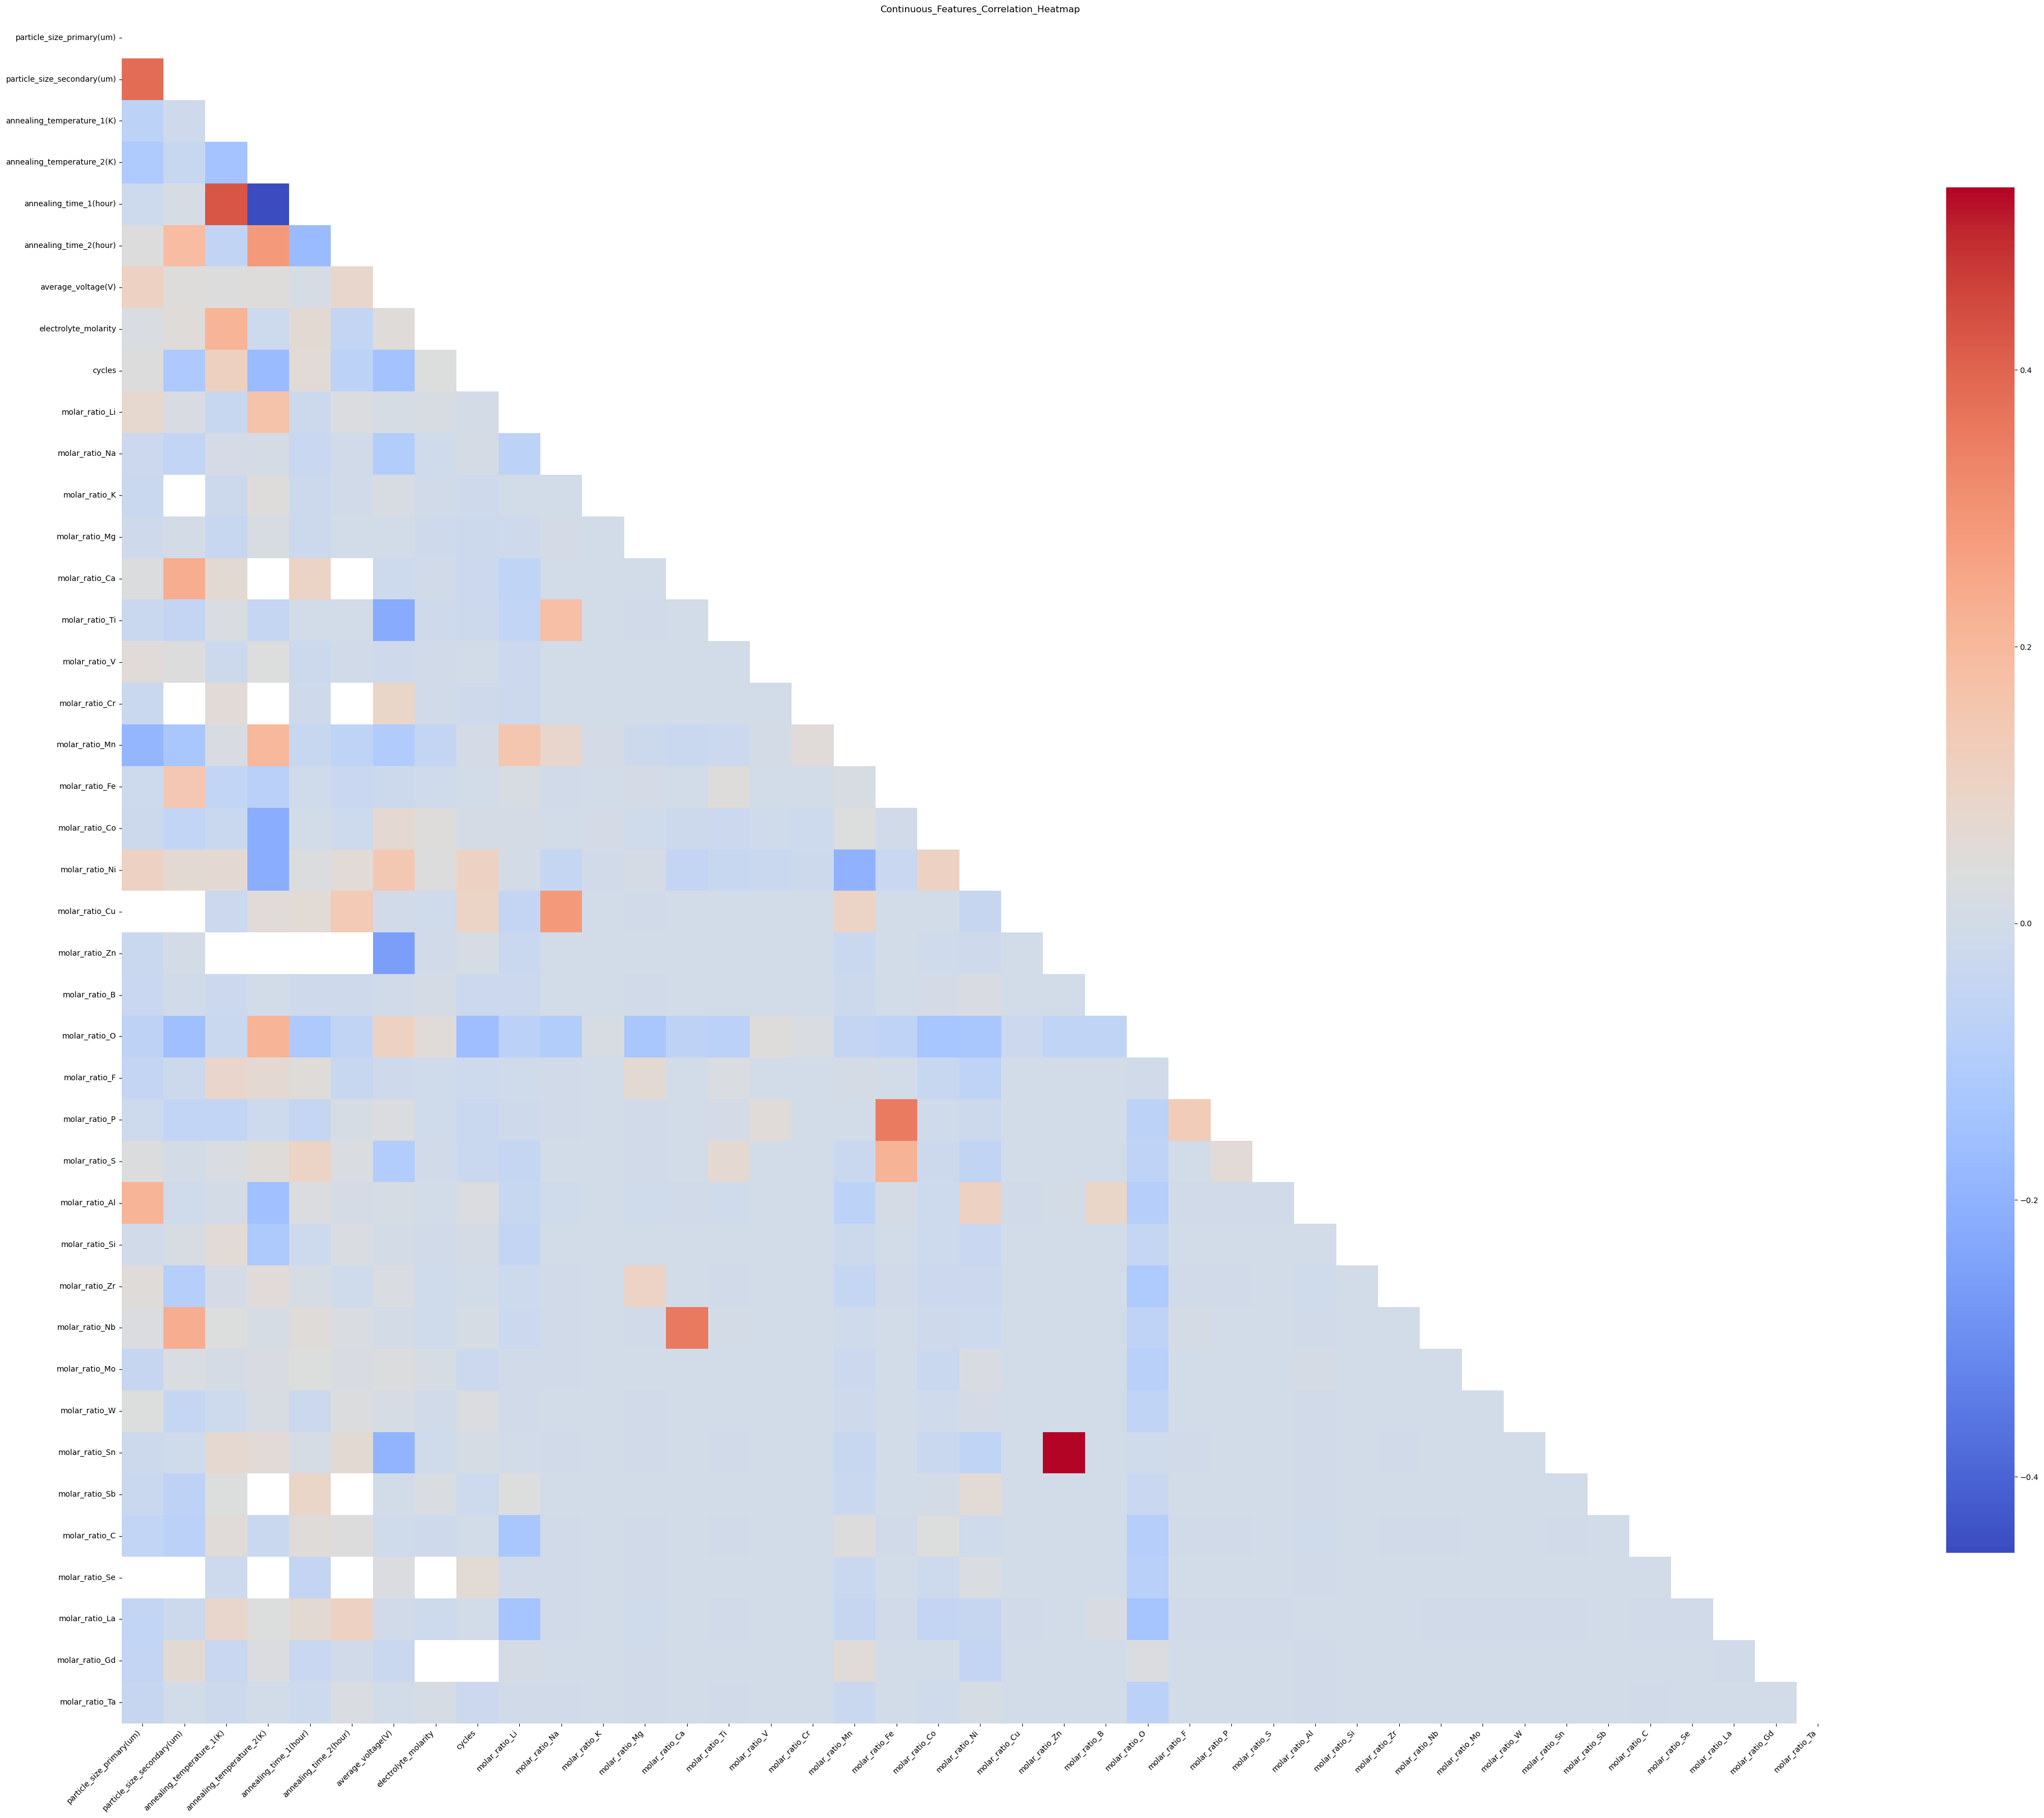

In [33]:
plot_correlation_heatmap(df=df_clip_continuous, save_dir=FEATURE_ENG_DIR, plot_title="Continuous Features Correlation Heatmap")

Binary features

Saved correlation heatmap: 'Binary_Features_Correlation_Heatmap.svg'


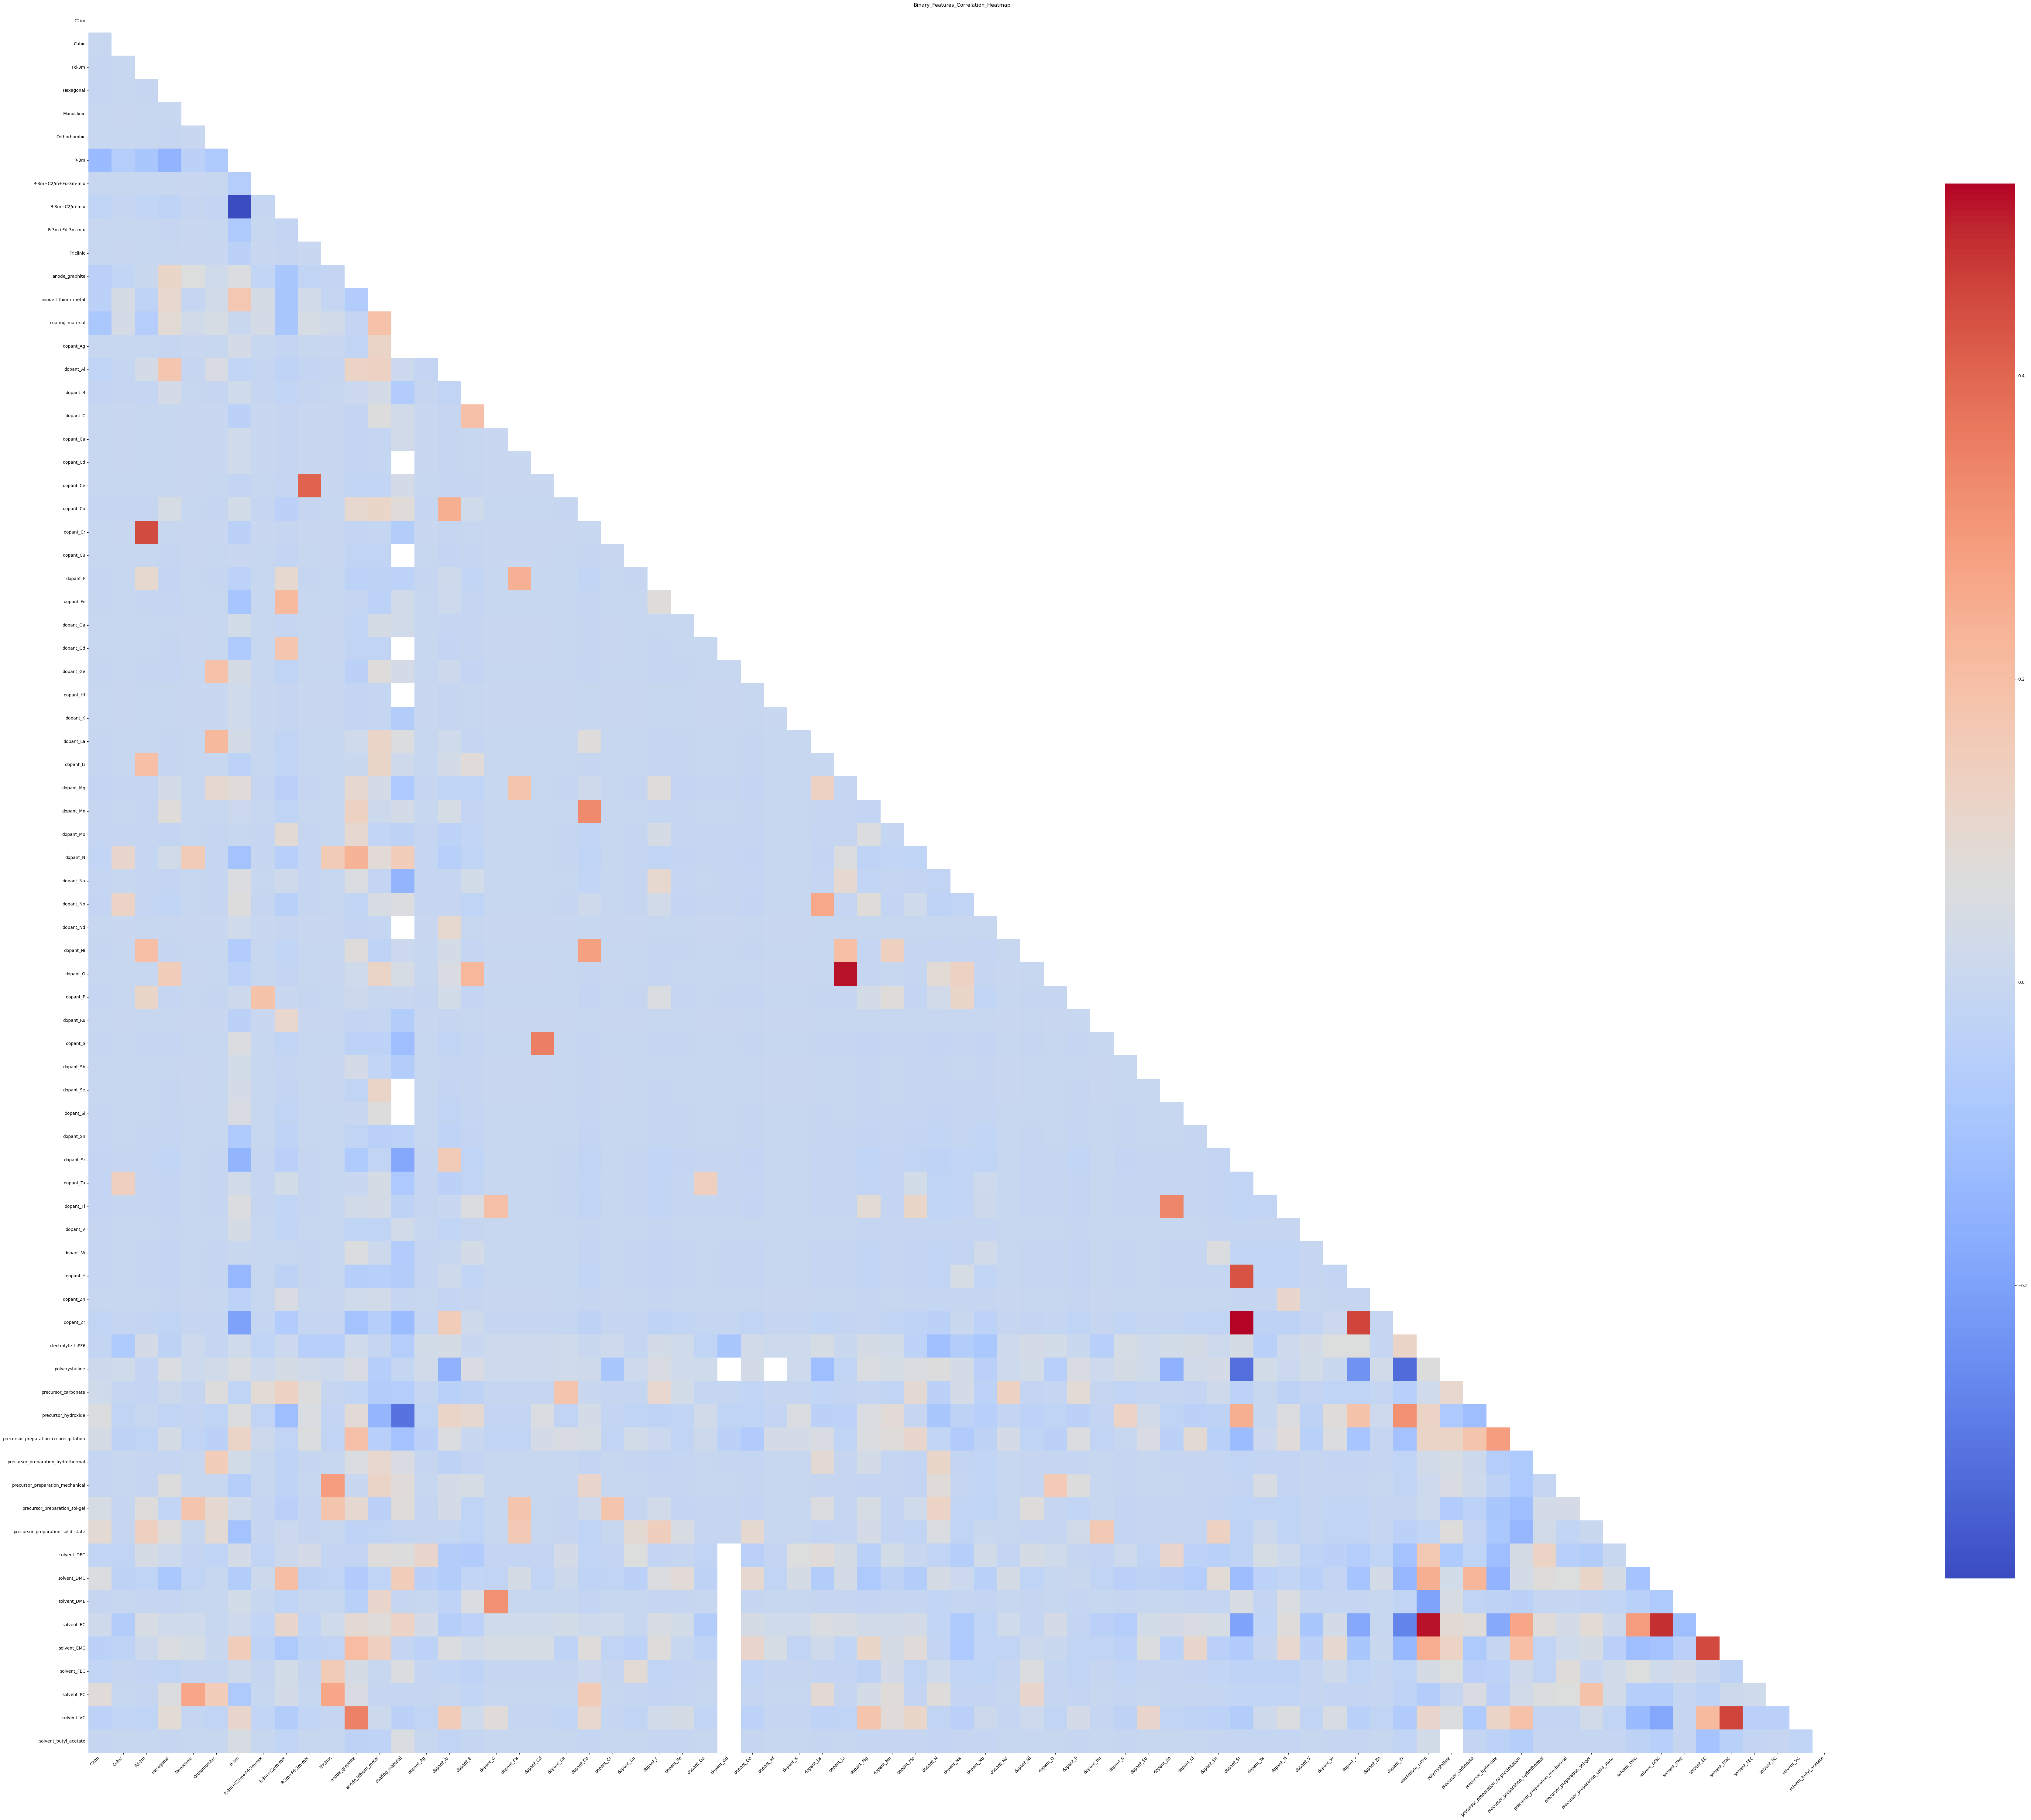

In [34]:
plot_correlation_heatmap(df=df_binary, save_dir=FEATURE_ENG_DIR, plot_title="Binary Features Correlation Heatmap")

## 8. Merge Dataframe

### 8.1 Check remaining nulls

In [35]:
show_null_columns(df_clip_targets)

,Missing Count,Missing %
first_coulombic_efficiency(%),518,42.46
capacity_retention(%),246,20.16
capacity(mAh/g),157,12.87


In [36]:
show_null_columns(df_clip_continuous)

,Missing Count,Missing %
particle_size_secondary(um),818,67.05
annealing_time_2(hour),708,58.03
annealing_temperature_2(K),688,56.39
particle_size_primary(um),676,55.41
electrolyte_molarity,517,42.38
cycles,379,31.07
annealing_time_1(hour),342,28.03
annealing_temperature_1(K),320,26.23
average_voltage(V),80,6.56


In [37]:
show_null_columns(df_binary)

,Missing Count,Missing %
coating_material,580,47.54
polycrystalline,461,37.79
solvent_DEC,115,9.43
solvent_DMC,115,9.43
solvent_DME,115,9.43
solvent_EC,115,9.43
solvent_EMC,115,9.43
solvent_FEC,115,9.43
solvent_PC,115,9.43
solvent_VC,115,9.43


### 8.2 Merge

In [38]:
df_processed_full = merge_dataframes(df_clip_continuous, df_binary, df_clip_targets)

DataFrame 1 shape: (1220, 41)
DataFrame 2 shape: (1220, 75)
DataFrame 3 shape: (1220, 3)
Merged DataFrame shape: (1220, 119)


## 9. Save dataset & Info

In [39]:
save_dataframe(df=df_processed_full, save_dir=ENGINEERED_CSVS_DIR, filename="engineered dataset")

✅ Saved dataset: 'engineered_dataset.csv' with shape: (1220, 119)


In [ ]:
serialize_object(obj=df_binary.columns.to_list(), save_dir=DATA_DIR, filename="BINARY_COLUMNS_list")
serialize_object(obj=df_clip_continuous.columns.to_list(), save_dir=DATA_DIR, filename="CONTINUOUS_COLUMNS_list")

✅ Object of type '<class 'list'>' saved to '/home/karl/lithium_battery/data/BINARY_COLUMNS_list.joblib'


'/home/karl/lithium_battery/data/BINARY_COLUMNS_list.joblib'